In [1]:
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
import os 
import sys 
import utils
%matplotlib inline

/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-package

---

# Hyperparameter

In [2]:
SHUFFLE_BUFFER = 4000
BATCH_SIZE = 16
lr = 0.000001
opt = tf.keras.optimizers.Adam(lr)
tfrecords_read_dir = '/home/kevinteng/Desktop/BRATS_stack/tfrecords/'

---

# Helper Functions

In [3]:
def dicesq(y_true, y_pred):
    '''
    Modified dice coefficient as refer to: https://arxiv.org/abs/1606.04797
    :param y_true: Ground truth
    :param y_pred: Prediction from the model
    :return: Modified dice coefficient
    '''
    nmr = 2*tf.reduce_sum(y_true*y_pred)
    dnmr = tf.reduce_sum(y_true**2) + tf.reduce_sum(y_pred**2) + tf.keras.backend.epsilon()
    return (nmr / dnmr)

def dicesq_loss(y_true, y_pred):
    '''
    Modified dice coefficient loss
    :param y_true: Ground truth
    :param y_pred: Prediction from the model
    '''
    return 1- dicesq(y_true, y_pred)

def dice_coef(y_true, y_pred):
    '''
    Dice coefficient for tensorflow
    '''
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + tf.keras.backend.epsilon()) / \
(tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + tf.keras.backend.epsilon())

def dice_coef_loss(y_true, y_pred):
    '''
    Dice coefficient loss for IOU
    '''
    return 1-dice_coef(y_true, y_pred)

def plot_comparison(input_img, caption, n_row=1, n_col=2, figsize=(10, 10), cmap = 'gray'):
    '''
    Plot comparison of multiple image but only in column wise!
    :param input_img: Input image list
    :param caption: Input caption list
    :param IMG_SIZE: Image size
    :param n_row: Number of row is 1 by DEFAULT
    :param n_col: Number of columns
    :param figsize: Figure size during plotting
    :return: Plot of (n_row, n_col)
    '''
    print()
    assert len(caption) == len(input_img), "Caption length and input image length does not match"
    assert len(input_img) == n_col, "Error of input images or number of columns!"

    fig, axes = plt.subplots(n_row, n_col, figsize=figsize)
    fig.subplots_adjust(hspace=0.4, wspace=0.4, right=0.7)

    for i in range(n_col):
        axes[i].imshow(np.squeeze(input_img[i]), cmap= cmap)
        axes[i].set_xlabel(caption[i])
        axes[i].set_xticks([])
        axes[i].set_yticks([])

    plt.tight_layout()
    plt.show()

----

# Model

In [4]:
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import InputLayer, Conv2DTranspose, Activation, BatchNormalization
from coord_conv import CoordConv

def conv_block(x_in, filters, batch_norm = False, kernel_size=(3,3)):
    x = Conv2D(filters, kernel_size, padding='same')(x_in)
    if batch_norm==True:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size, padding='same')(x)
    if batch_norm==True:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def coordconv_block(x_in, x_dim, y_dim, filters, batch_norm = False, kernel_size=(3,3), with_r = False):
    x = Conv2D(filters, kernel_size, padding='same')(x_in)
    if batch_norm==True:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = CoordConv(x_dim, y_dim, with_r, filters, kernel_size, padding='same')(x)
    if batch_norm==True:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def conv_2d(x_in, filters, batch_norm = False, kernel_size=(3,3),acti ='relu'):
    x = Conv2D(filters, kernel_size, padding='same')(x_in)
    if batch_norm==True:
        x=BatchNormalization()(x)
    x= Activation(acti)(x)
    return x
    
def pool(x_in, pool_size=(2, 2), type='Max'):
    if type=='Max':
        p = MaxPooling2D(pool_size)(x_in)
    return p

def up(x_in, filters, merge, batch_norm = False, size=(2,2)):
    u = UpSampling2D(size)(x_in)
    conv = conv_2d(u, filters, batch_norm)
    concat = tf.concat([merge, conv],axis=-1)
    return concat
    
def Unet_model(input_layer):
    #downsampling
    conv1 = coordconv_block(input_layer, x_dim=240, y_dim=240, filters=64, batch_norm = True)
    pool1 = pool(conv1)
    
    conv2 = conv_block(pool1, filters=128, batch_norm = True)
    pool2 = pool(conv2)
    
    conv3 = conv_block(pool2, filters=256, batch_norm = True)
    pool3 = pool(conv3)
    
    conv4 = conv_block(pool3, filters=512, batch_norm = True)
    pool4 = pool(conv4)
    
    conv5 = conv_block(pool4, filters=1024, batch_norm = True)
    
    #upsampling
    up1 = up(conv5,filters=512, merge=conv4, batch_norm = True)
    conv6 = coordconv_block(up1, x_dim=30, y_dim=30, filters=512, batch_norm = True)
    
    up2 = up(conv6, filters=256, merge=conv3, batch_norm = True)
    conv7 = conv_block(up2, filters=256, batch_norm = True)
    
    up3 = up(conv7, filters=128, merge=conv2, batch_norm = True)
    conv8 = conv_block(up3, filters=128, batch_norm = True)
    
    up4 = up(conv8, filters=64, merge=conv1, batch_norm = True)
    conv9 = conv_block(up4, filters=64, batch_norm = True)
    
    #on paper filters = 2
    output_layer = conv_2d(conv9, filters=1, kernel_size=(1,1), acti='sigmoid')
    
    return output_layer

In [5]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input

input_layer = Input(shape=(240,240,1))
Unet = Model(input_layer, Unet_model(input_layer))

In [6]:
#to do..Sensitivity
@tf.function
def train_fn(image, label):
    with tf.GradientTape() as tape:
        model_output = Unet(image)
        loss = dice_coef_loss(label, model_output)
    gradients = tape.gradient(loss, Unet.trainable_variables)
    opt.apply_gradients(zip(gradients, Unet.trainable_variables))
    
    return model_output, loss, gradients

Epochs  1

HGG_lbl_complete_tumor_HGG_training_MR_Flair.tfrecords




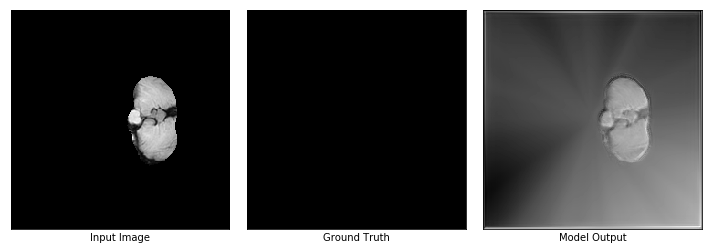

Steps: 100, Loss:0.9641660451889038, Dice Coefficient: 0.03583395481109619
Gradient min:-0.001229308545589447, max:0.001176666934043169



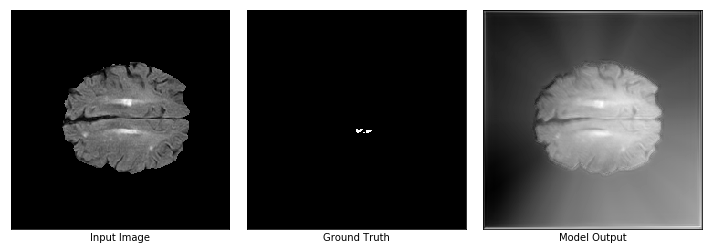

Steps: 200, Loss:0.9627764225006104, Dice Coefficient: 0.03722357749938965
Gradient min:-0.0014251845423132181, max:0.001193480216898024



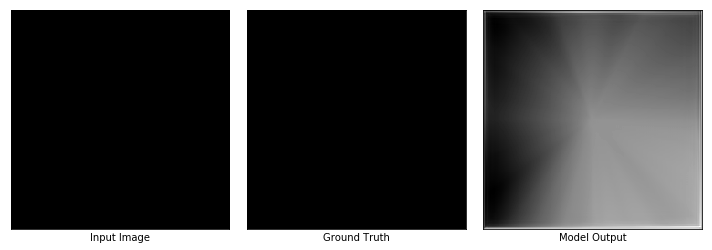

Steps: 300, Loss:0.9784688353538513, Dice Coefficient: 0.02153116464614868
Gradient min:-0.0009340303367935121, max:0.0005393654573708773



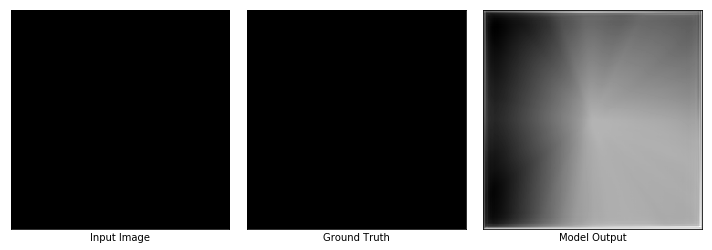

Steps: 400, Loss:0.9862556457519531, Dice Coefficient: 0.013744354248046875
Gradient min:-0.0005632045213133097, max:0.000318886071909219



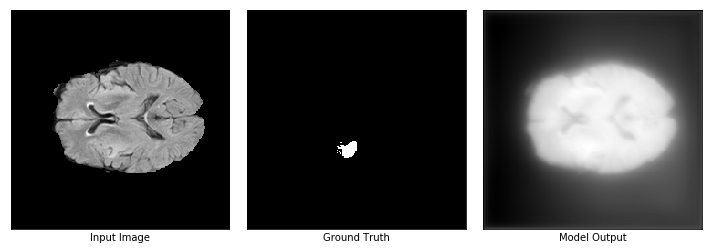

Steps: 500, Loss:0.9719916582107544, Dice Coefficient: 0.028008341789245605
Gradient min:-0.0022502995561808348, max:0.0010308028431609273



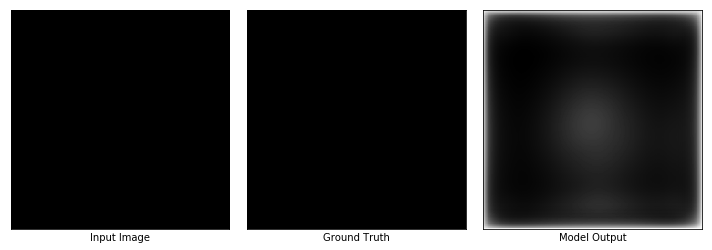

Steps: 600, Loss:0.8661819696426392, Dice Coefficient: 0.13381803035736084
Gradient min:-0.013701445423066616, max:0.004580683074891567



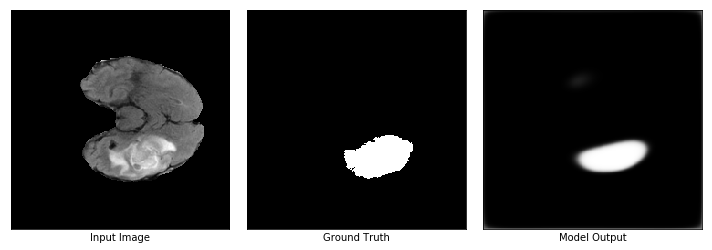

Steps: 700, Loss:0.6056536436080933, Dice Coefficient: 0.39434635639190674
Gradient min:-0.07709971815347672, max:0.026453880593180656



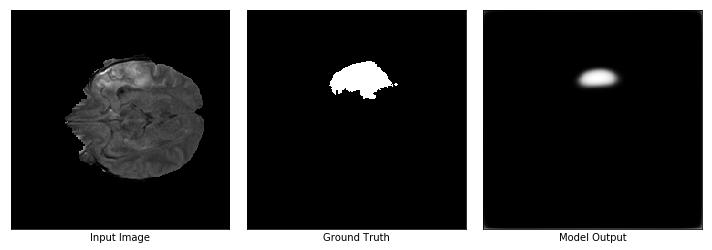

Steps: 800, Loss:0.6687265634536743, Dice Coefficient: 0.3312734365463257
Gradient min:-0.3342283368110657, max:0.12872111797332764



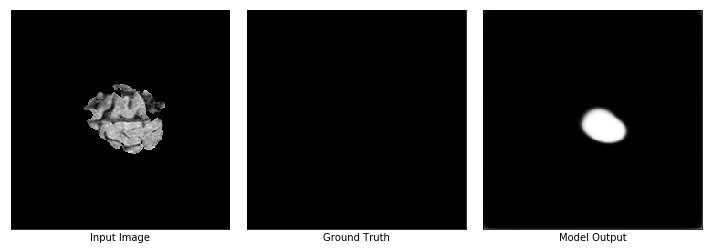

Steps: 900, Loss:0.4899477958679199, Dice Coefficient: 0.5100522041320801
Gradient min:-0.11591091752052307, max:0.0508146658539772



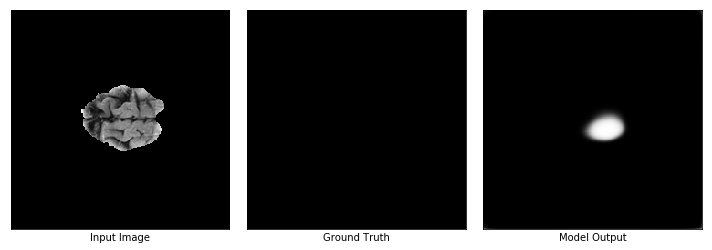

Steps: 1000, Loss:0.49457287788391113, Dice Coefficient: 0.5054271221160889
Gradient min:-0.24018028378486633, max:0.08383915573358536



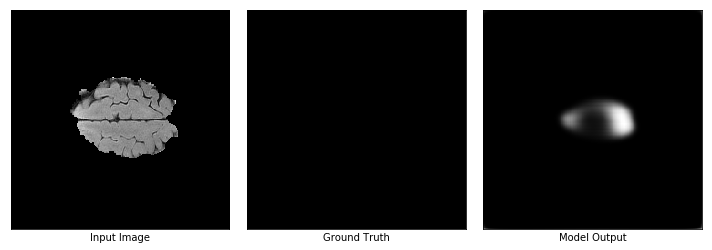

Steps: 1100, Loss:0.41367876529693604, Dice Coefficient: 0.586321234703064
Gradient min:-0.02509172074496746, max:0.024913350120186806



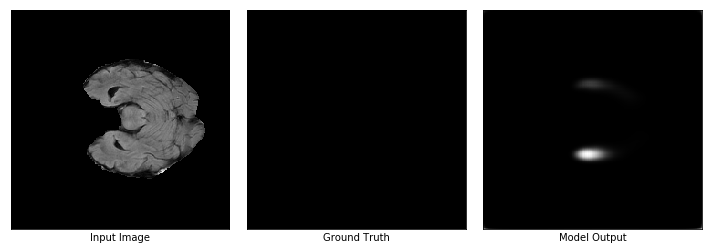

Steps: 1200, Loss:0.6636781096458435, Dice Coefficient: 0.3363218903541565
Gradient min:-0.12897703051567078, max:0.37409403920173645



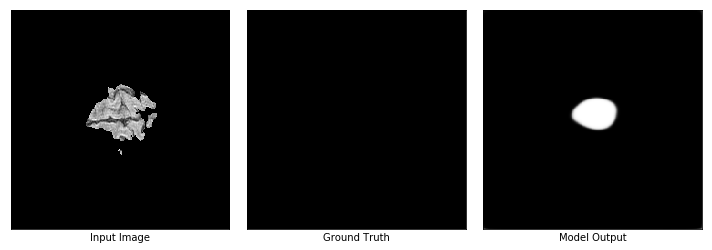

Steps: 1300, Loss:0.6740182638168335, Dice Coefficient: 0.3259817361831665
Gradient min:-0.04049544781446457, max:0.03184853866696358



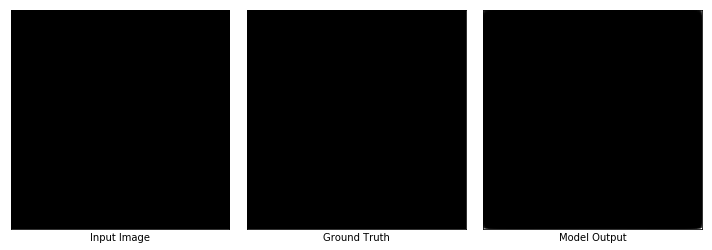

Steps: 1400, Loss:0.32272613048553467, Dice Coefficient: 0.6772738695144653
Gradient min:-0.0215610321611166, max:0.061199042946100235



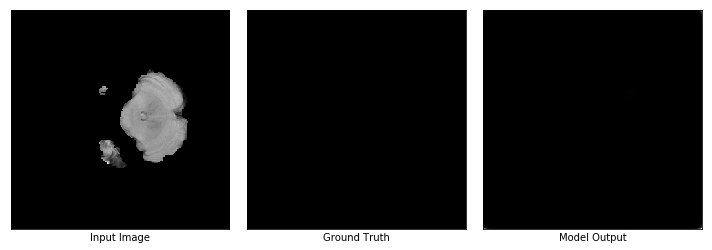

Steps: 1500, Loss:0.44696855545043945, Dice Coefficient: 0.5530314445495605
Gradient min:-0.09693952649831772, max:0.04120693355798721



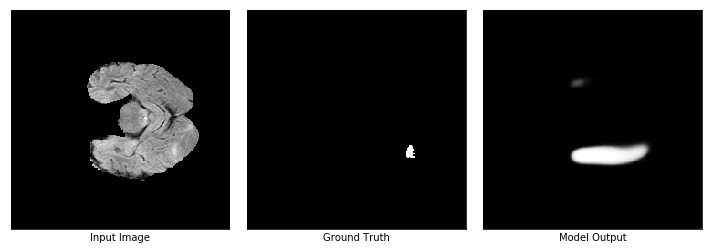

Steps: 1600, Loss:0.5417472124099731, Dice Coefficient: 0.45825278759002686
Gradient min:-0.11252688616514206, max:0.043171390891075134



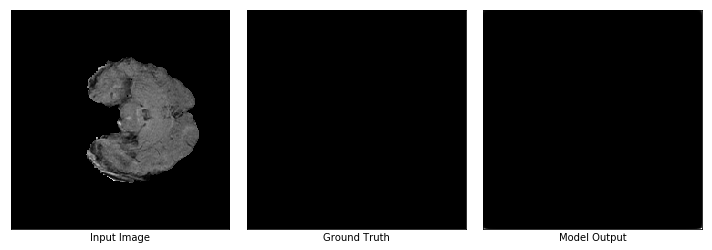

Steps: 1700, Loss:0.708825945854187, Dice Coefficient: 0.291174054145813
Gradient min:-0.10950879752635956, max:0.11060197651386261



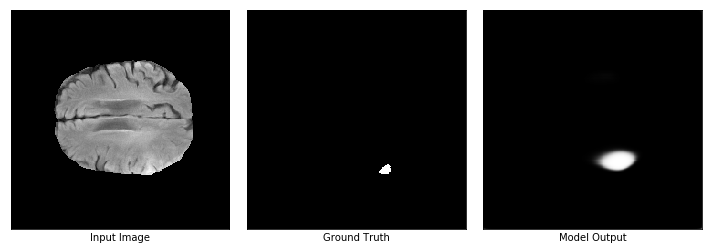

Steps: 1800, Loss:0.4463220238685608, Dice Coefficient: 0.5536779761314392
Gradient min:-0.02804468758404255, max:0.09107454866170883



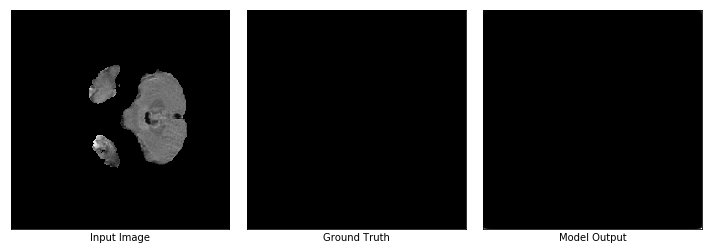

Steps: 1900, Loss:0.44709235429763794, Dice Coefficient: 0.5529076457023621
Gradient min:-0.13283754885196686, max:0.06317389756441116



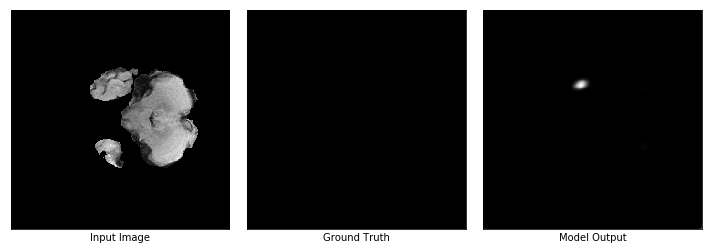

Steps: 2000, Loss:0.29311877489089966, Dice Coefficient: 0.7068812251091003
Gradient min:-0.07482686638832092, max:0.020730135962367058



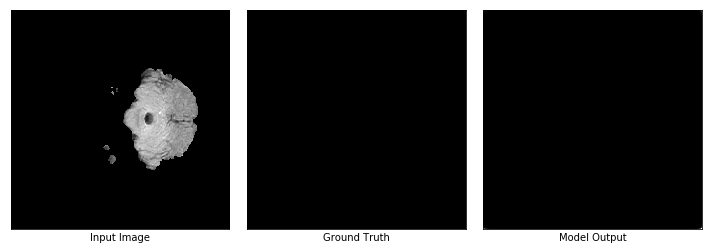

Steps: 2100, Loss:0.40384721755981445, Dice Coefficient: 0.5961527824401855
Gradient min:-0.043935999274253845, max:0.02554769441485405

Average Dice Coefficient: 0.3985176384449005
HGG_lbl_complete_tumor_HGG_training_MR_T1.tfrecords




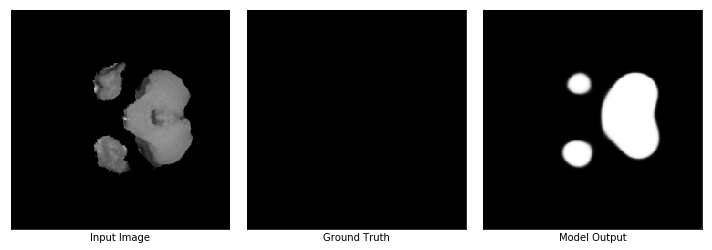

Steps: 2200, Loss:0.7886605858802795, Dice Coefficient: 0.21133941411972046
Gradient min:-0.023012133315205574, max:0.004666920285671949



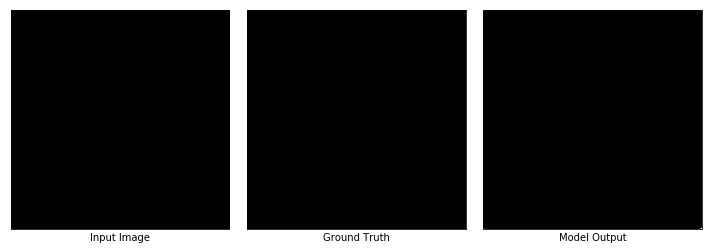

Steps: 2300, Loss:0.7907693982124329, Dice Coefficient: 0.20923060178756714
Gradient min:-0.00803279411047697, max:0.031422968953847885



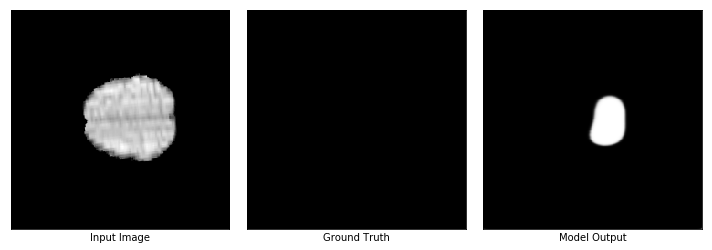

Steps: 2400, Loss:0.841602623462677, Dice Coefficient: 0.158397376537323
Gradient min:-0.010407108813524246, max:0.0024584627244621515



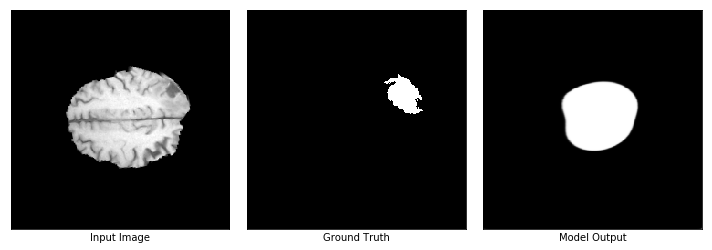

Steps: 2500, Loss:0.8387043476104736, Dice Coefficient: 0.16129565238952637
Gradient min:-0.01203064527362585, max:0.005477894563227892



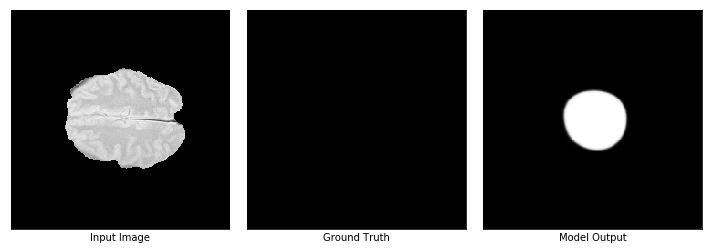

Steps: 2600, Loss:0.809848427772522, Dice Coefficient: 0.19015157222747803
Gradient min:-0.025468705222010612, max:0.00828159973025322



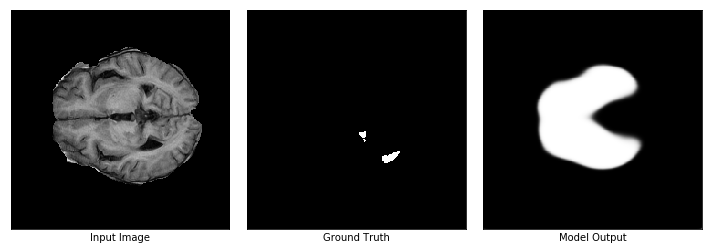

Steps: 2700, Loss:0.812726616859436, Dice Coefficient: 0.18727338314056396
Gradient min:-0.009038713760674, max:0.028074778616428375



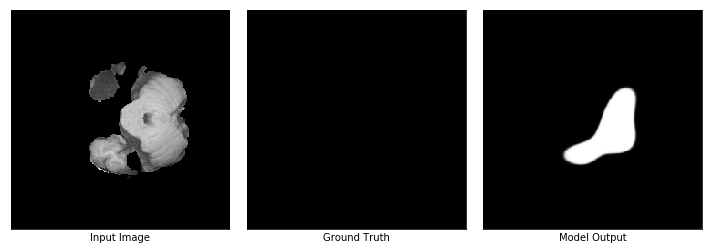

Steps: 2800, Loss:0.836175262928009, Dice Coefficient: 0.16382473707199097
Gradient min:-0.019148051738739014, max:0.004462860058993101



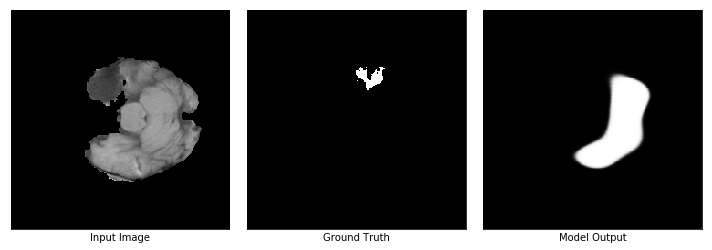

Steps: 2900, Loss:0.8089568614959717, Dice Coefficient: 0.19104313850402832
Gradient min:-0.016855981200933456, max:0.00954220537096262



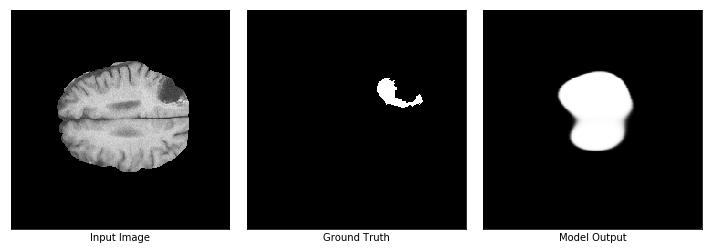

Steps: 3000, Loss:0.8191821575164795, Dice Coefficient: 0.1808178424835205
Gradient min:-0.027830908074975014, max:0.04880383983254433



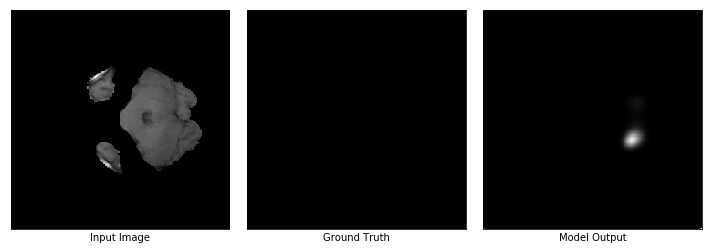

Steps: 3100, Loss:0.7916012406349182, Dice Coefficient: 0.2083987593650818
Gradient min:-0.03333976864814758, max:0.020690156146883965



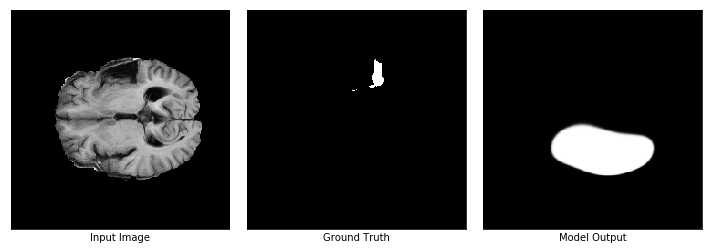

Steps: 3200, Loss:0.7898270487785339, Dice Coefficient: 0.21017295122146606
Gradient min:-0.017388926818966866, max:0.03440505266189575



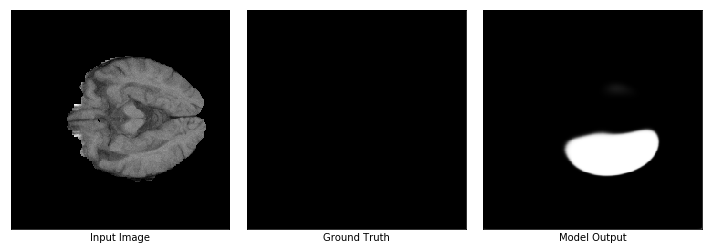

Steps: 3300, Loss:0.7938348650932312, Dice Coefficient: 0.2061651349067688
Gradient min:-0.02292187325656414, max:0.02319446951150894



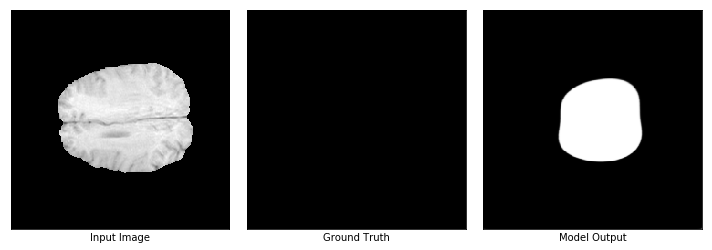

Steps: 3400, Loss:0.8372666239738464, Dice Coefficient: 0.16273337602615356
Gradient min:-0.01302353385835886, max:0.01712116226553917



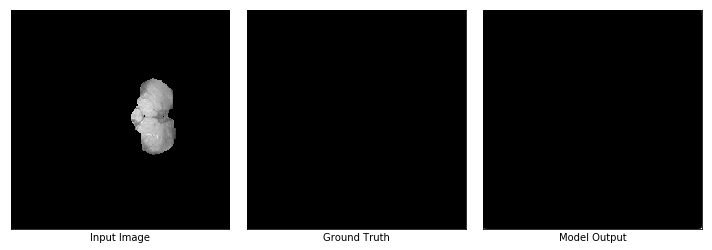

Steps: 3500, Loss:0.6940921545028687, Dice Coefficient: 0.30590784549713135
Gradient min:-0.0288495272397995, max:0.024031609296798706



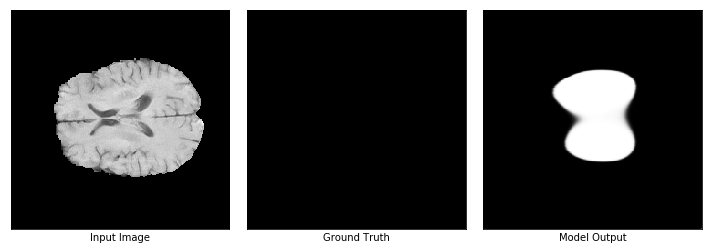

Steps: 3600, Loss:0.7410813570022583, Dice Coefficient: 0.2589186429977417
Gradient min:-0.025661835446953773, max:0.01714806817471981



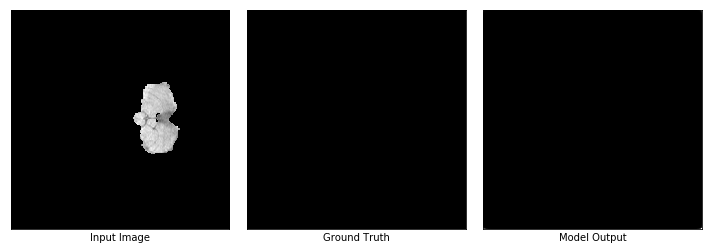

Steps: 3700, Loss:0.8509893417358398, Dice Coefficient: 0.14901065826416016
Gradient min:-0.008776632137596607, max:0.024180736392736435



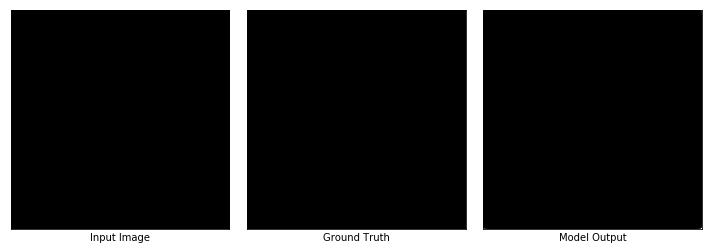

Steps: 3800, Loss:0.6967986226081848, Dice Coefficient: 0.3032013773918152
Gradient min:-0.010810633189976215, max:0.03820309415459633



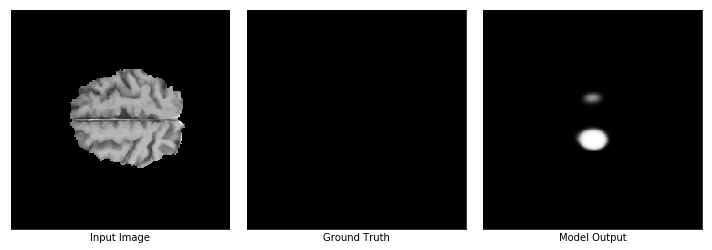

Steps: 3900, Loss:0.8518590927124023, Dice Coefficient: 0.14814090728759766
Gradient min:-0.08114807307720184, max:0.04220311716198921



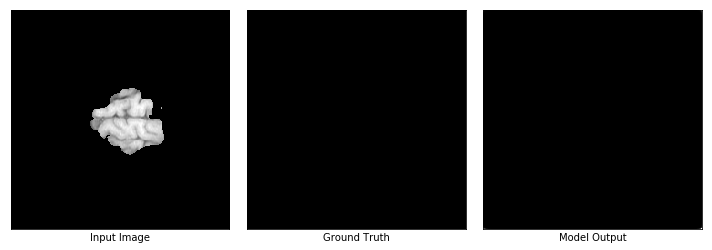

Steps: 4000, Loss:0.797532320022583, Dice Coefficient: 0.202467679977417
Gradient min:-0.02286539226770401, max:0.01498755905777216



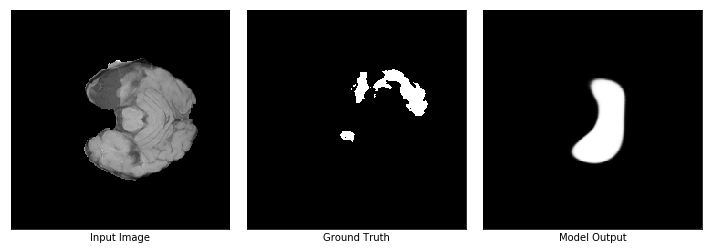

Steps: 4100, Loss:0.6237824559211731, Dice Coefficient: 0.3762175440788269
Gradient min:-0.00961808580905199, max:0.01732371747493744



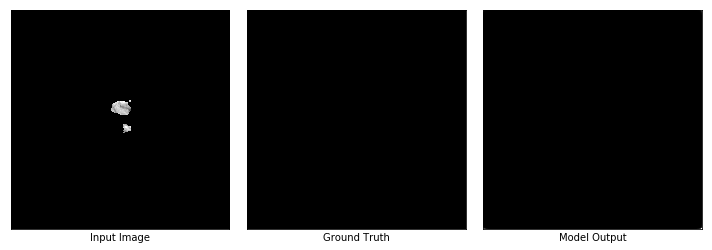

Steps: 4200, Loss:0.5953441262245178, Dice Coefficient: 0.4046558737754822
Gradient min:-0.05082578584551811, max:0.02806592918932438

Average Dice Coefficient: 0.29753148555755615
HGG_lbl_complete_tumor_HGG_training_MR_T1c.tfrecords




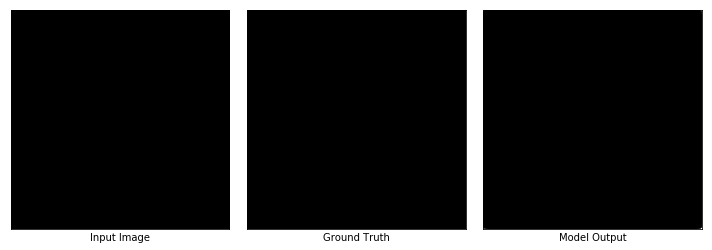

Steps: 4300, Loss:0.8089193105697632, Dice Coefficient: 0.19108068943023682
Gradient min:-0.034061726182699203, max:0.01529636513441801



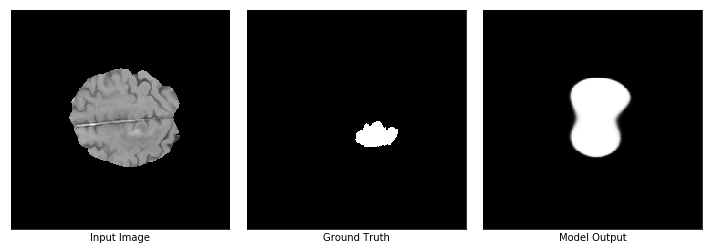

Steps: 4400, Loss:0.8170793652534485, Dice Coefficient: 0.1829206347465515
Gradient min:-0.006932826247066259, max:0.007759351283311844



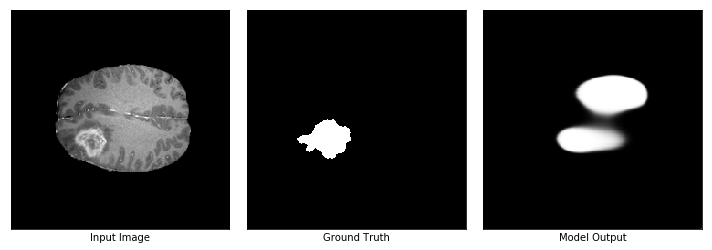

Steps: 4500, Loss:0.735373854637146, Dice Coefficient: 0.264626145362854
Gradient min:-0.019359325990080833, max:0.01675230637192726



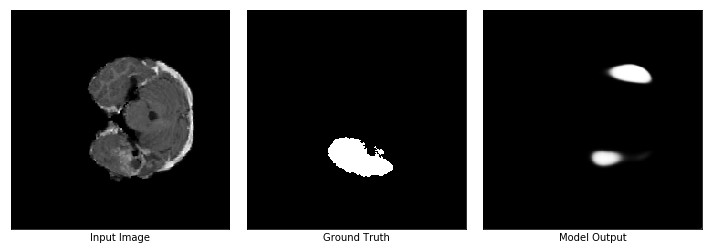

Steps: 4600, Loss:0.7506259679794312, Dice Coefficient: 0.24937403202056885
Gradient min:-0.05212625861167908, max:0.0479789562523365



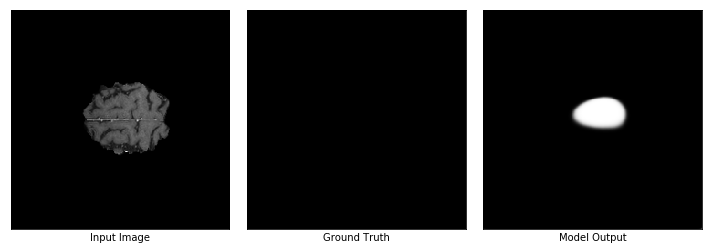

Steps: 4700, Loss:0.7721222639083862, Dice Coefficient: 0.22787773609161377
Gradient min:-0.053466301411390305, max:0.015559910796582699



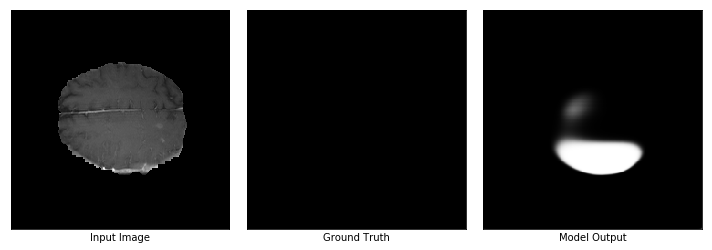

Steps: 4800, Loss:0.7060831785202026, Dice Coefficient: 0.29391682147979736
Gradient min:-0.04553164914250374, max:0.13964872062206268



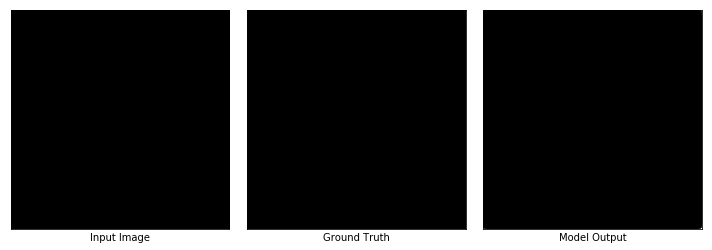

Steps: 4900, Loss:0.5174741744995117, Dice Coefficient: 0.4825258255004883
Gradient min:-0.024958902969956398, max:0.06583897769451141



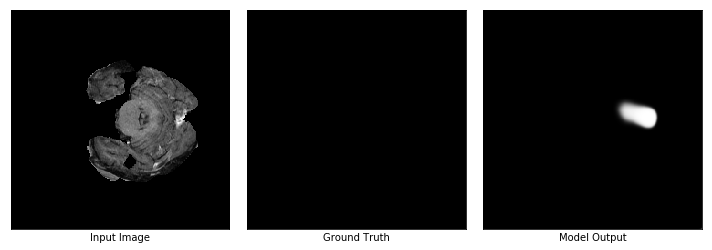

Steps: 5000, Loss:0.6549288034439087, Dice Coefficient: 0.3450711965560913
Gradient min:-0.011415829882025719, max:0.018299274146556854



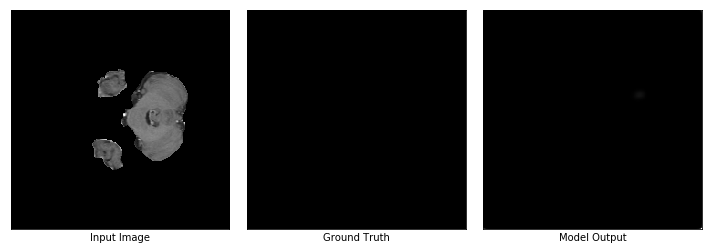

Steps: 5100, Loss:0.6556397676467896, Dice Coefficient: 0.34436023235321045
Gradient min:-0.03333691135048866, max:0.051438119262456894



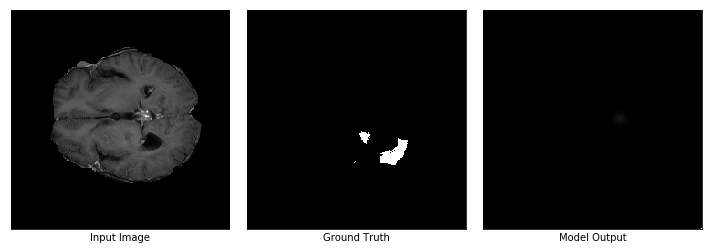

Steps: 5200, Loss:0.6122826337814331, Dice Coefficient: 0.3877173662185669
Gradient min:-0.05054381489753723, max:0.09510104358196259



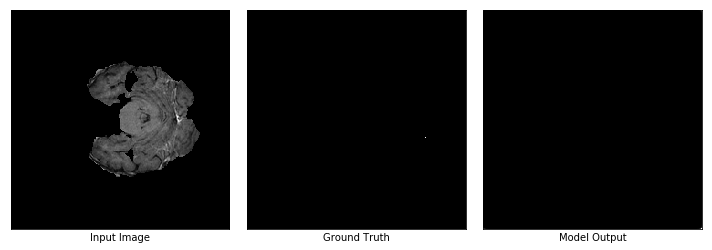

Steps: 5300, Loss:0.7570366859436035, Dice Coefficient: 0.24296331405639648
Gradient min:-0.12405283749103546, max:0.05502043291926384



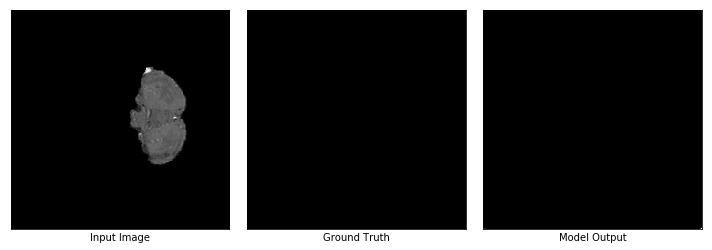

Steps: 5400, Loss:0.41582125425338745, Dice Coefficient: 0.5841787457466125
Gradient min:-0.0757785513997078, max:0.0871465876698494



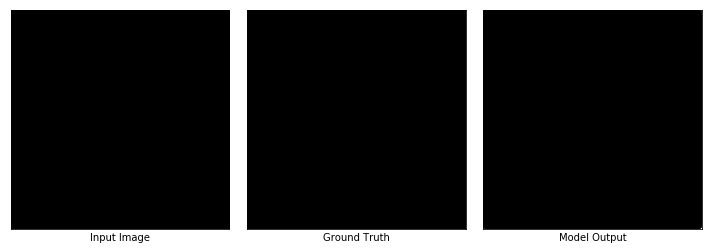

Steps: 5500, Loss:0.4151532053947449, Dice Coefficient: 0.5848467946052551
Gradient min:-0.020806770771741867, max:0.032711371779441833



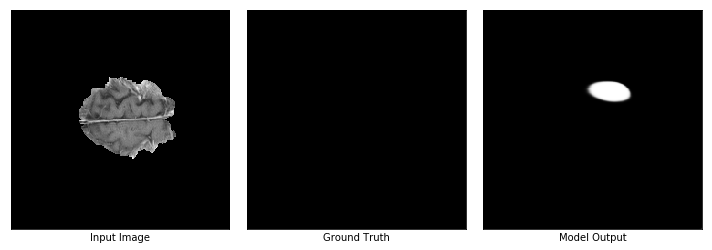

Steps: 5600, Loss:0.6592108011245728, Dice Coefficient: 0.34078919887542725
Gradient min:-0.0467250794172287, max:0.18555684387683868



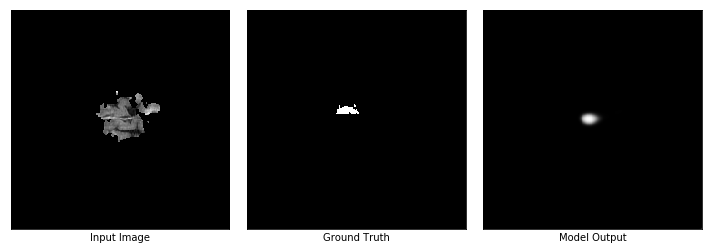

Steps: 5700, Loss:0.7397047877311707, Dice Coefficient: 0.26029521226882935
Gradient min:-0.033595599234104156, max:0.067063108086586



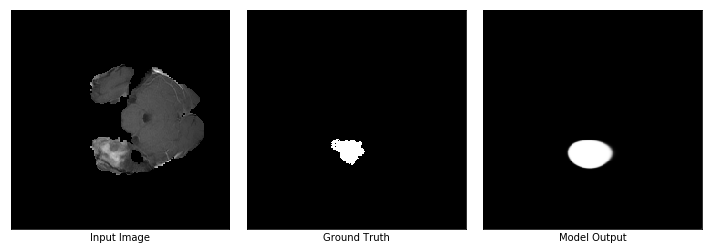

Steps: 5800, Loss:0.5402343273162842, Dice Coefficient: 0.4597656726837158
Gradient min:-0.03119940310716629, max:0.07527894526720047



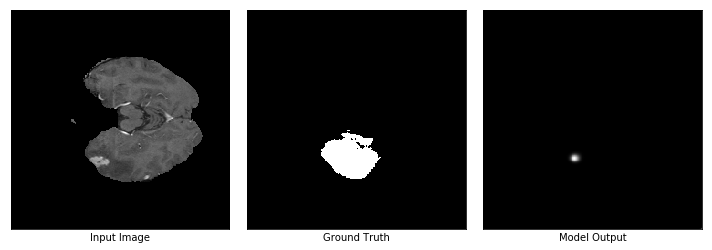

Steps: 5900, Loss:0.6713161468505859, Dice Coefficient: 0.32868385314941406
Gradient min:-0.2523060142993927, max:0.0848378986120224



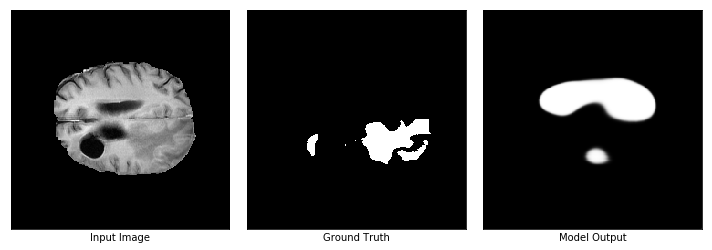

Steps: 6000, Loss:0.6717849373817444, Dice Coefficient: 0.3282150626182556
Gradient min:-0.05885368958115578, max:0.037527620792388916



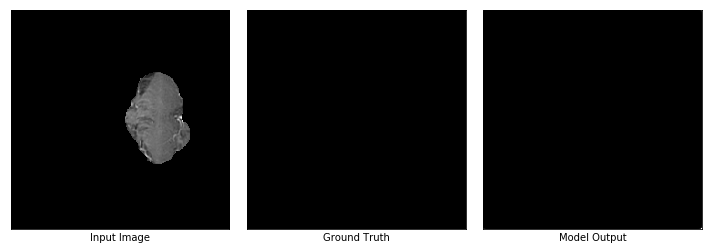

Steps: 6100, Loss:0.49637824296951294, Dice Coefficient: 0.5036217570304871
Gradient min:-0.06028084456920624, max:0.0642007440328598



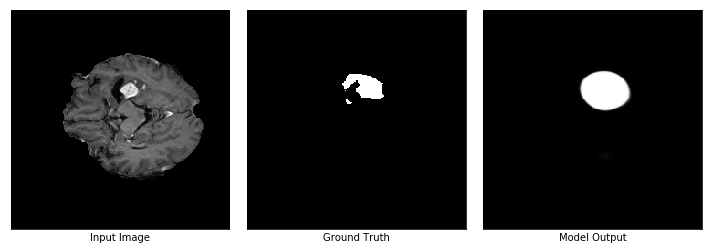

Steps: 6200, Loss:0.6213656067848206, Dice Coefficient: 0.37863439321517944
Gradient min:-0.0853600725531578, max:0.02338310517370701



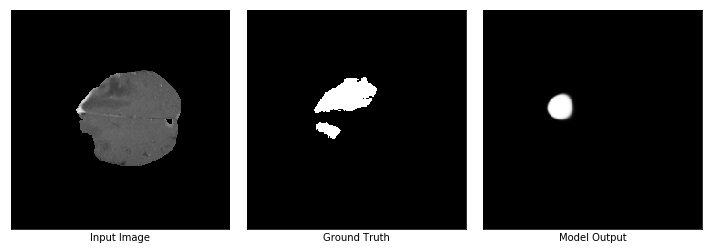

Steps: 6300, Loss:0.33968669176101685, Dice Coefficient: 0.6603133082389832
Gradient min:-0.058679644018411636, max:0.07219408452510834

Average Dice Coefficient: 0.30816158652305603
HGG_lbl_complete_tumor_HGG_training_MR_T2.tfrecords




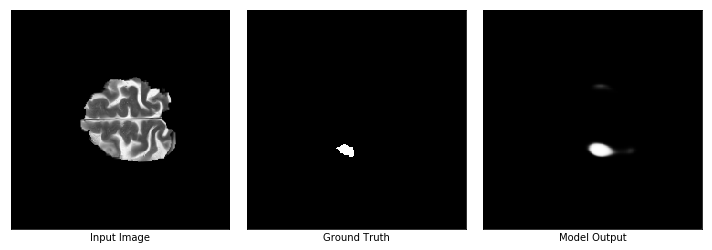

Steps: 6400, Loss:0.529860258102417, Dice Coefficient: 0.470139741897583
Gradient min:-0.044101569801568985, max:0.16230377554893494



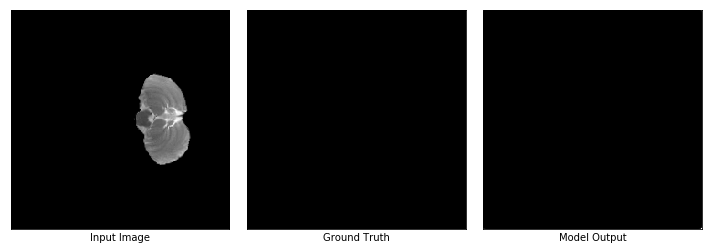

Steps: 6500, Loss:0.28028786182403564, Dice Coefficient: 0.7197121381759644
Gradient min:-0.049639880657196045, max:0.12867452204227448



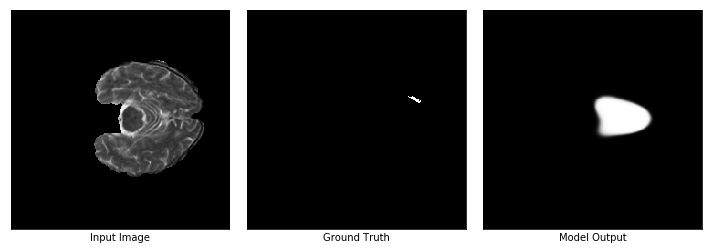

Steps: 6600, Loss:0.5999288558959961, Dice Coefficient: 0.4000711441040039
Gradient min:-0.06726378202438354, max:0.22200588881969452



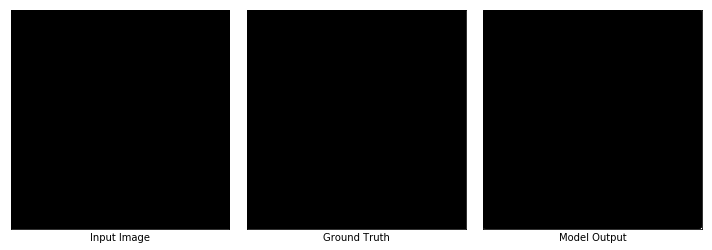

Steps: 6700, Loss:0.5071262121200562, Dice Coefficient: 0.49287378787994385
Gradient min:-0.2549414336681366, max:0.07234103232622147



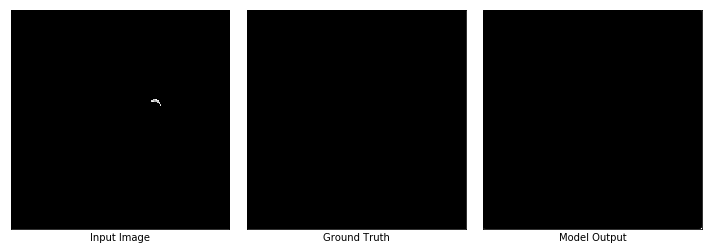

Steps: 6800, Loss:0.5355085134506226, Dice Coefficient: 0.46449148654937744
Gradient min:-0.038711559027433395, max:0.16191869974136353



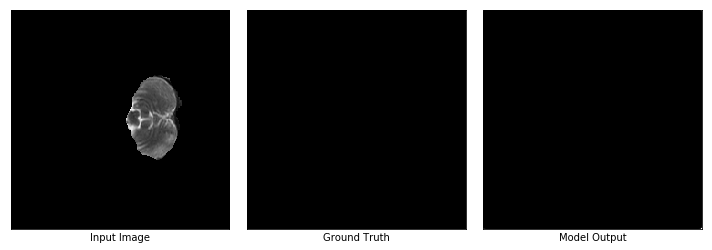

Steps: 6900, Loss:0.727705180644989, Dice Coefficient: 0.272294819355011
Gradient min:-0.1993488073348999, max:0.09864822775125504



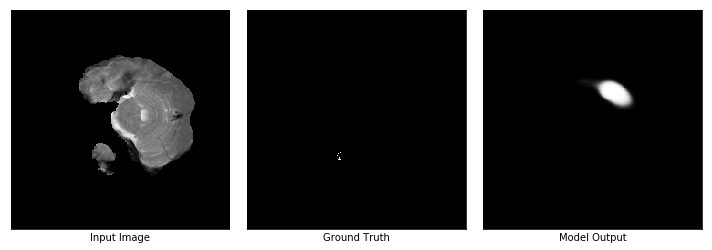

Steps: 7000, Loss:0.7424840927124023, Dice Coefficient: 0.25751590728759766
Gradient min:-0.05035128444433212, max:0.05245913937687874



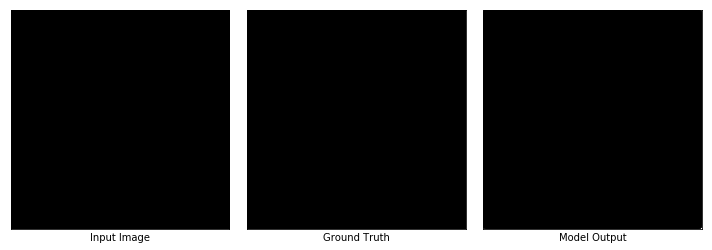

Steps: 7100, Loss:0.5071138143539429, Dice Coefficient: 0.49288618564605713
Gradient min:-0.03504202887415886, max:0.11220932006835938



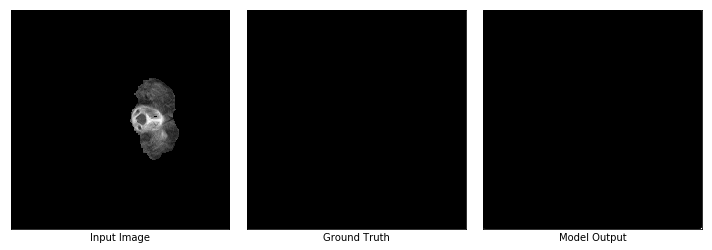

Steps: 7200, Loss:0.6571532487869263, Dice Coefficient: 0.34284675121307373
Gradient min:-0.22365319728851318, max:0.061815906316041946



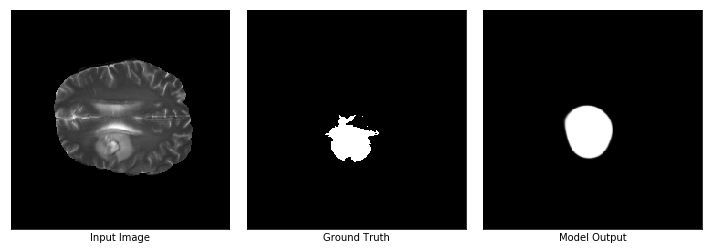

Steps: 7300, Loss:0.36765992641448975, Dice Coefficient: 0.6323400735855103
Gradient min:-0.03439825400710106, max:0.08602255582809448



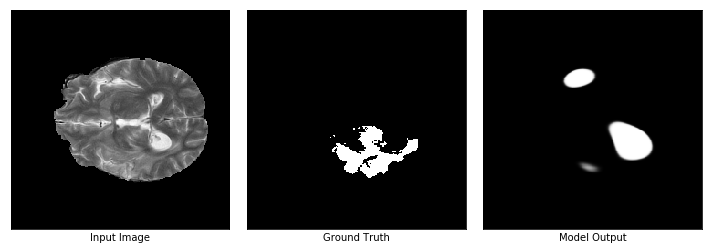

Steps: 7400, Loss:0.48107701539993286, Dice Coefficient: 0.5189229846000671
Gradient min:-0.04231009632349014, max:0.08398398756980896



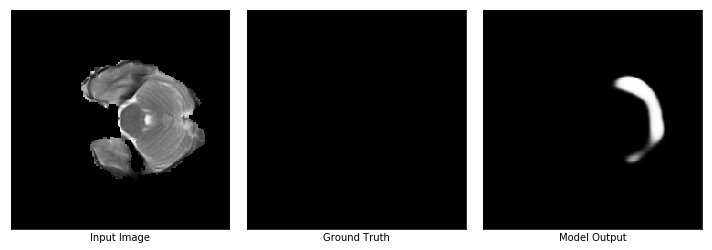

Steps: 7500, Loss:0.7570732235908508, Dice Coefficient: 0.24292677640914917
Gradient min:-0.051670823246240616, max:0.10724625736474991



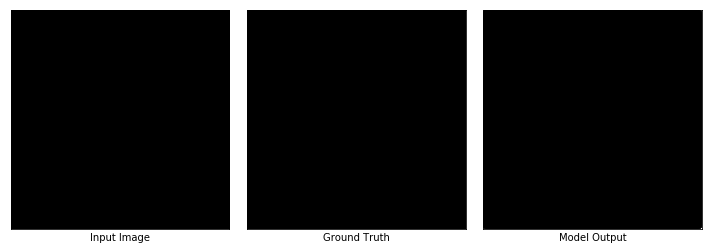

Steps: 7600, Loss:0.6254627704620361, Dice Coefficient: 0.37453722953796387
Gradient min:-0.02294851839542389, max:0.032539986073970795



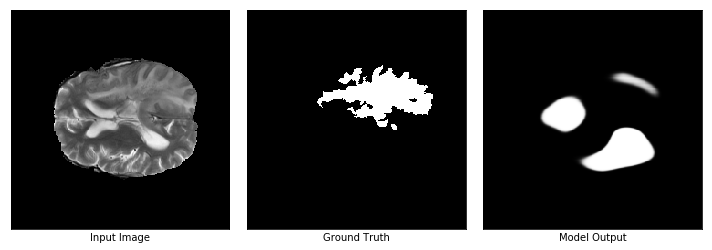

Steps: 7700, Loss:0.6310650706291199, Dice Coefficient: 0.3689349293708801
Gradient min:-0.16903898119926453, max:0.051400747150182724



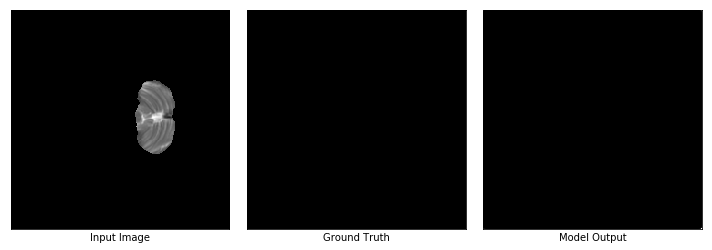

Steps: 7800, Loss:0.468955934047699, Dice Coefficient: 0.531044065952301
Gradient min:-0.2056380957365036, max:0.07151665538549423



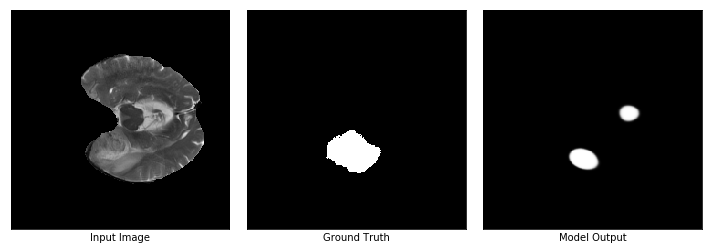

Steps: 7900, Loss:0.5036326050758362, Dice Coefficient: 0.4963673949241638
Gradient min:-0.038311172276735306, max:0.050316888839006424



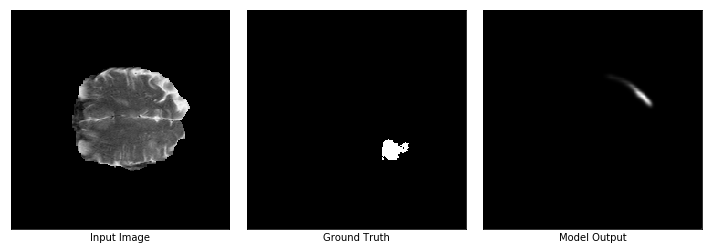

Steps: 8000, Loss:0.6438292860984802, Dice Coefficient: 0.3561707139015198
Gradient min:-0.0859425738453865, max:0.024037698283791542



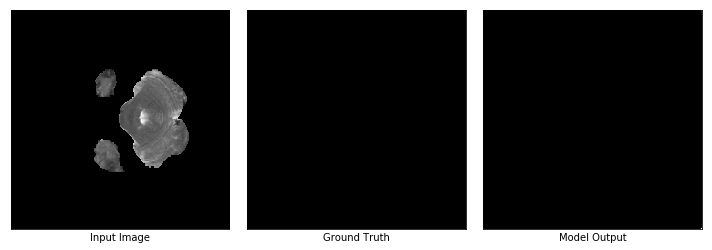

Steps: 8100, Loss:0.701759934425354, Dice Coefficient: 0.298240065574646
Gradient min:-0.053206901997327805, max:0.139621764421463



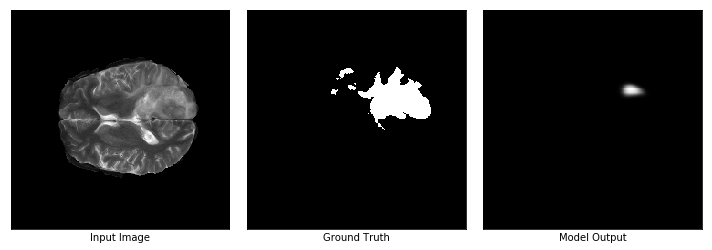

Steps: 8200, Loss:0.322451651096344, Dice Coefficient: 0.677548348903656
Gradient min:-0.05297446623444557, max:0.019590485841035843



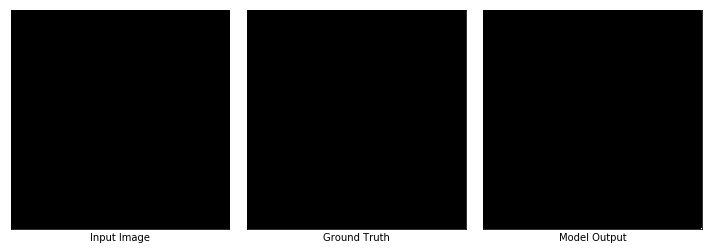

Steps: 8300, Loss:0.4196348190307617, Dice Coefficient: 0.5803651809692383
Gradient min:-0.02601476199924946, max:0.048630375415086746



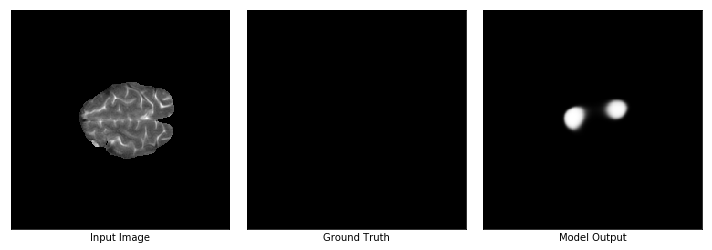

Steps: 8400, Loss:0.5430651307106018, Dice Coefficient: 0.4569348692893982
Gradient min:-0.11837118864059448, max:0.27885955572128296



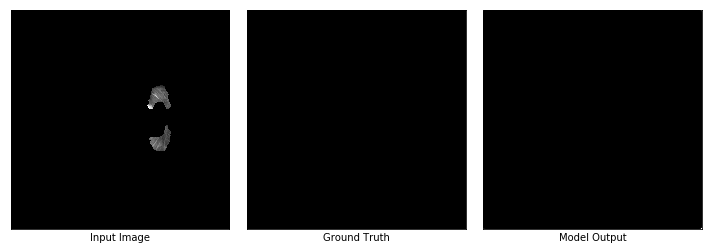

Steps: 8500, Loss:0.5988332033157349, Dice Coefficient: 0.40116679668426514
Gradient min:-0.3233632445335388, max:0.2004457414150238

Average Dice Coefficient: 0.3400225043296814


In [7]:
epochs = 1
max_epochs = 1
predicted_img = []
groundtruth_img = []
loss_list = []
dice_list = []
while epochs <= max_epochs:
    print("Epochs {:2d}".format(epochs))
    print()
    steps = 1
    for tf_re in sorted(os.listdir(tfrecords_read_dir)):
        print(tf_re)
        print()
        tf_dir = os.path.join(tfrecords_read_dir+tf_re)
        dataset = utils.parse_tfrecord(tf_dir).shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE)
        for image, label in dataset:
            image = tf.reshape(image, [-1, 240, 240, 1]) #(batch_size, img_size, img_size, channel)
            label = tf.reshape(label, [-1, 240, 240, 1]) #(batch_size, img_size, img_size, channel)
            img_seg, loss, gradients = train_fn(image, label) #training function 
            dice_score = 1 - loss #calculate dice score 
            
            dice_list.append(dice_score) #append dice score for every every images
            
            #output
            if steps%100==0:
                input_img = [image[0], label[0], img_seg[0]]
                caption = ['Input Image', 'Ground Truth', 'Model Output']
                plot_comparison(input_img, caption, n_col = 3)
                
                predicted_img.append(img_seg[0])
                groundtruth_img.append(label[0])
                loss_list.append(loss)
                print("Steps: {}, Loss:{}, Dice Coefficient: {}".format(steps, loss, dice_score))
                print("Gradient min:{}, max:{}".format(np.min(gradients[0]), np.max(gradients[0])))
            steps+=1
        print()
        print("Average Dice Coefficient: {}".format(np.mean(np.array(dice_list))))
    epochs+=1 

---

# Model Summary

In [8]:
Unet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 240, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 240, 240, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 240, 240, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 240, 240, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________